# Treemix Ag1000G phase2
For build a dataset Treemix I need unlinked SNPs. So I have to prune my allele count datasets to obtain SNPs in high LD.
For doing this I need:
    - Phase2 Genotype callset
    - Phase2 Allele count
    - Outgroup Allele count

In this notebook I edited an old Alistair's notebook of the Phase1 of Ag1000G (<b>20151001 treemix prep 4</b>). On my phase2 datasets I have already the biallelic allele counts so I skipped the searching and filtering for biallelic SNPs

Import my modules:

In [1]:
%run imports.ipynb

In [2]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=30)
cluster

In [3]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://10.35.63.149:41401 Dashboard: /user/carlo%20mariade%20marco1/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


Import callsets:

In [5]:
callset_pass= callset_biallel
allele_counts= zarr.open('data/phase2_biallel_allele_count.zarr/')
outgroup_allele_counts= zarr.open('data/outgroup_alleles_phase2.zarr/')

------------------------

Define functions to locate biallelic allele counts on a range for my outgroup and phase2 datasets:

In [6]:
def outgroup_ascertainment(chrom, start, stop, outgroups):
    
    # locate region
    pos = allel.SortedIndex(callset_pass[chrom]['variants']['POS'][:])
    locr = pos.locate_range(start, stop)
    
    # ascertain SNPs
    loca = np.zeros(pos.shape, dtype='b1')
    loca[locr] = True
    loca = dask.array.from_array(loca)
    log('outgroup ascertainment, initial', nnz(loca))
    for s in outgroups:
        ac = allel.AlleleCountsDaskArray(outgroup_allele_counts[chrom][s][:])
        # non-missing
        locs = (ac.sum(axis=1) > 0)
        loca &= locs
      
        log(s, nnz(loca))
        
    return loca
        

In [7]:
def ingroup_ascertainment(chrom, start, stop, segpops):

    # locate region
    pos = allel.SortedIndex(callset_pass[chrom]['variants']['POS'][:])
    locr = pos.locate_range(start, stop)

    # ascertain SNPs
    loca = np.zeros(pos.shape, dtype='b1')
    loca[locr] = True
    loca = dask.array.from_array(loca)
    log('ingroup ascertainment, initial', nnz(loca))

    
    # require segregating
    for pop in segpops:
        ac = allel.AlleleCountsDaskArray(allele_counts[chrom][pop][:])
        loc_seg = ac.min(axis=1) > 0
        
        loca &= loc_seg
        log('after require segregating in', pop, nnz(loca))
        
    return loca

Define function for ld pruning. LD-pruning remove SNPs with an high correlation. Using windows this function compute pairwise LD between all SNPs within each window, then removing one SNP from each correlated pair.

In [8]:
def downsample_and_prune(chrom, start, stop, loc_asc,
                         n=100000, ldp_size=500, ldp_step=250, ldp_threshold=.1, ldp_n_iter=1):

    # all variant positions
    pos = allel.SortedIndex(callset_pass[chrom]['variants']['POS'][:])
    posa = pos[loc_asc]

    # randomly downsample
    if n < posa.shape[0]:
        posds = np.random.choice(posa, n, replace=False)
        posds.sort()
        posds = allel.SortedIndex(posds)
    else:
        # skip downsampling
        posds = posa
    locds = pos.locate_keys(posds)    

    # load genotype data
    genotype = allel.GenotypeChunkedArray(callset_pass[chrom]['calldata/GT'])
    geno_subset = genotype.subset(sel0=loc_asc)
    gn = geno_subset.to_n_alt()

    
    # prune    
    for i in range(ldp_n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=ldp_size, step=ldp_step, threshold=ldp_threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        log('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gnu = gn.compress(loc_unlinked, axis=0)
        posu = pos.compress(loc_unlinked)
        locu = pos.locate_keys(posu)

    return locu

Define function for generating treemix file:

In [9]:
def to_treemix(acs, fn):
    pops = sorted(acs.keys())
    n_variants = acs[pops[0]].shape[0]
    n_alleles = acs[pops[0]].shape[1]
    assert n_alleles == 2, 'only biallelic variants supported'
    for pop in pops[1:]:
        assert n_variants == acs[pop].shape[0], 'bad number of variants for pop %s' % pop
        assert n_alleles == acs[pop].shape[1], 'bad number of alleles for pop %s' % pop
        
    with open(fn, 'wt', encoding='ascii') as f:
        print(' '.join(pops), file=f)
        for i in range(n_variants):
            print(' '.join([','.join(map(str, acs[pop][i])) for pop in pops]), file=f)


Define last function, the analysis function that includes all function below and applies these on my populations, outgroups, chromosomes of interest.

In [20]:
def run_analysis(rname, chrom, start, stop, segpops,
                 n=100000, ldp_size=500, ldp_step=250, ldp_threshold=.1, ldp_n_iter=1):

    # removed outgroups
    # initial ascertainment
    #loc_og_asc = outgroup_ascertainment(chrom, start, stop, outgroups=outgroups)
    loc_ig_asc = ingroup_ascertainment(chrom, start, stop, segpops=segpops)
    loc_asc =  loc_ig_asc ## loc_og_asc & 
    log('initial ascertainment', nnz(loc_asc))
    
    # downsample and prune
    locu = downsample_and_prune(chrom, start, stop, loc_asc, 
                                n=n, ldp_size=ldp_size, ldp_step=ldp_step, 
                                ldp_threshold=ldp_threshold, ldp_n_iter=ldp_n_iter)
    
    # write allele counts
    acsu = dict()
    for pop in populations:
        acsu[pop] = allele_counts[chrom][pop][:, :2][locu]
    #for pop in outgroups:
        #acsu[pop] = outgroup_allele_counts[chrom][pop][:, :2][locu]

    outdir = 'd/data/treemix/seg_%s_ldp_%s' % ('_'.join(segpops), ldp_n_iter) # '_'.join(outgroups),
    !mkdir -pv {outdir}
    fn = os.path.join(outdir, '%s.allele_counts.txt' % rname)
    to_treemix(acsu, fn)
    !gzip -fv {fn}


Declaring values for generating my treemix file and ran on it for chromosome 3R, 3L, X, and the X region involved on speciation between <i>An.gambiae</i> and <i>An.coluzzii</i>

In [21]:
#outgroups = ['arab', 'quad', 'meru', 'mela', 'chri']
segpops = ['AOcol', 'BFcol', 'CIcol', 'GHcol', 'GNcol','GHgam', 'CMgam', 'BFgam', 'GNgam', 'GQgam', 'UGgam', 'GAgam', 'FRgam','KE', 'GM', 'GW']
n = 100000
ldp_n_iter = 1
region_X_speciation = 'X-speciation', 'X', 15000000, 24000000 
region_X_free = 'X-free', 'X', 1, 14000000 
region_3L_free = '3L-free', '3L', 15000000, 41000000
region_3R_free = '3R-free', '3R', 1, 37000000 

In [22]:
rname, chrom, start, stop = region_3R_free
log(rname, chrom, start, stop)
run_analysis(rname, chrom, start, stop, segpops,n=n, ldp_n_iter=ldp_n_iter) #outgroups

3R-free 3R 1 37000000
ingroup ascertainment, initial dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=()>
after require segregating in AOcol dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=()>
after require segregating in BFcol dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=()>
after require segregating in CIcol dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=()>
after require segregating in GHcol dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=()>
after require segregating in GNcol dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=()>
after require segregating in GHgam dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=()>
after require segregating in CMgam dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=()>
after require segregating in BFgam dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=()>
after require segregating in GNgam dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=()>
af

In [24]:
rname, chrom, start, stop = region_3L_free
log(rname, chrom, start, stop)
run_analysis(rname, chrom, start, stop, segpops, n=n, ldp_n_iter=ldp_n_iter)

3L-free 3L 15000000 41000000
ingroup ascertainment, initial dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=()>
after require segregating in AOcol dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=()>
after require segregating in BFcol dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=()>
after require segregating in CIcol dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=()>
after require segregating in GHcol dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=()>
after require segregating in GNcol dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=()>
after require segregating in GHgam dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=()>
after require segregating in CMgam dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=()>
after require segregating in BFgam dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=()>
after require segregating in GNgam dask.array<sum-aggregate, shape=(), dtype=int64, chunksize

In [ ]:
rname, chrom, start, stop = region_X_free
log(rname, chrom, start, stop)
run_analysis(rname, chrom, start, stop, outgroups, segpops, n=n, ldp_n_iter=ldp_n_iter)

In [ ]:
rname, chrom, start, stop = region_X_speciation
log(rname, chrom, start, stop)
run_analysis(rname, chrom, start, stop, outgroups, segpops, n=n, ldp_n_iter=ldp_n_iter)

## Treemix

Total SNPs per chromosomes:
- <b>3L-free</b>: 27609 SNPs
- <b>3R-free</b>: 40187 SNPs
- <b>X-free</b>: 1794 SNPs
- <b>X-speciation</b>: 37 SNPs

I ran treemix using as option bootstrap -k 500 and represented in R with  `plot_tree function`

In [2]:
from IPython.display import Image

### 3L-free

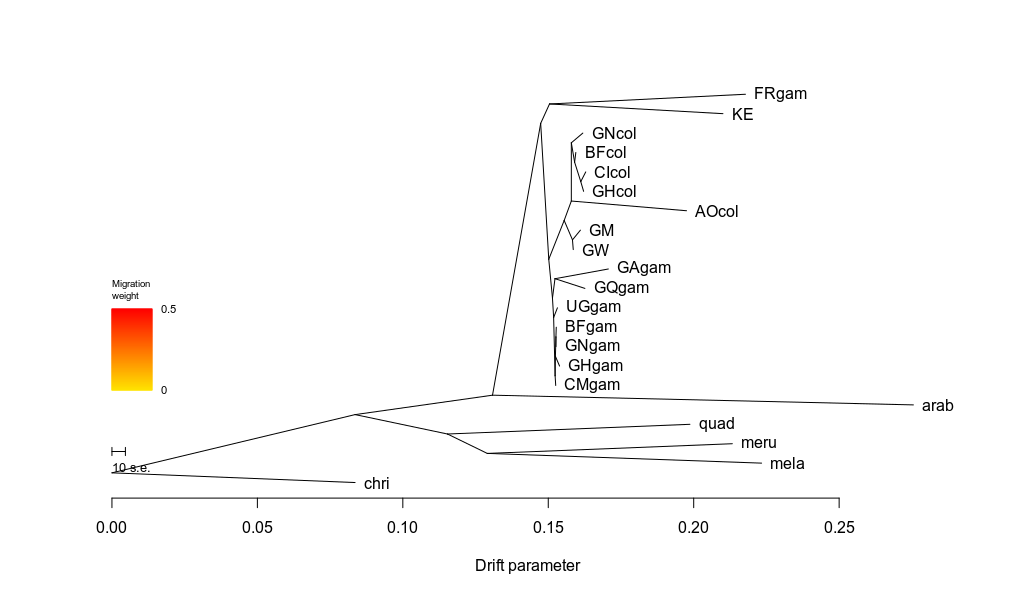

In [3]:
Image(filename='/home/randomx/Dropbox/Ag1000G_carlo/notebooks/images/treemix/3L_free.png')

### 3R-free

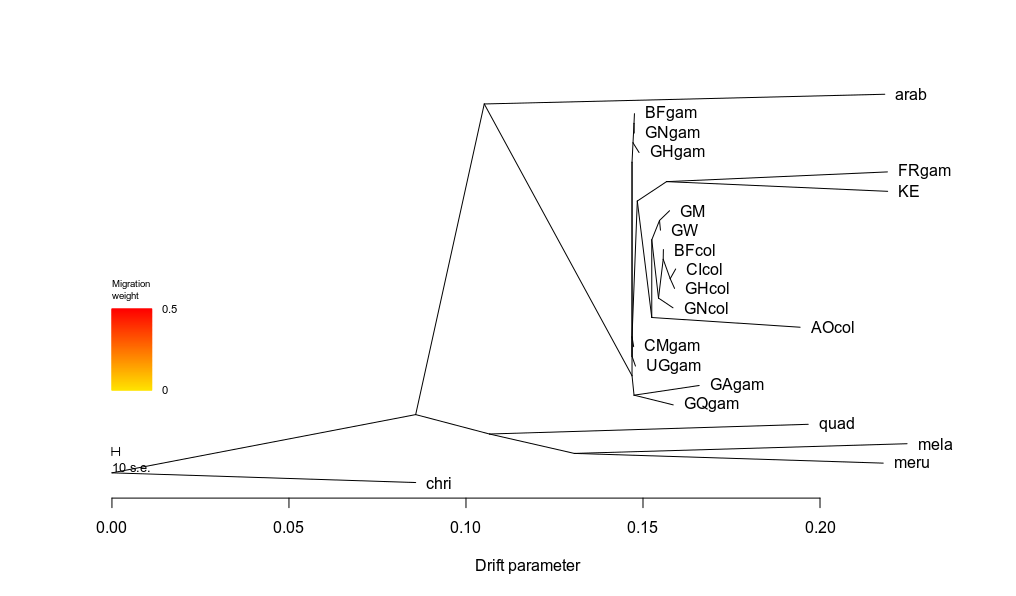

In [4]:
Image(filename='/home/randomx/Dropbox/Ag1000G_carlo/notebooks/images/treemix/3R_free.png')

### X-free

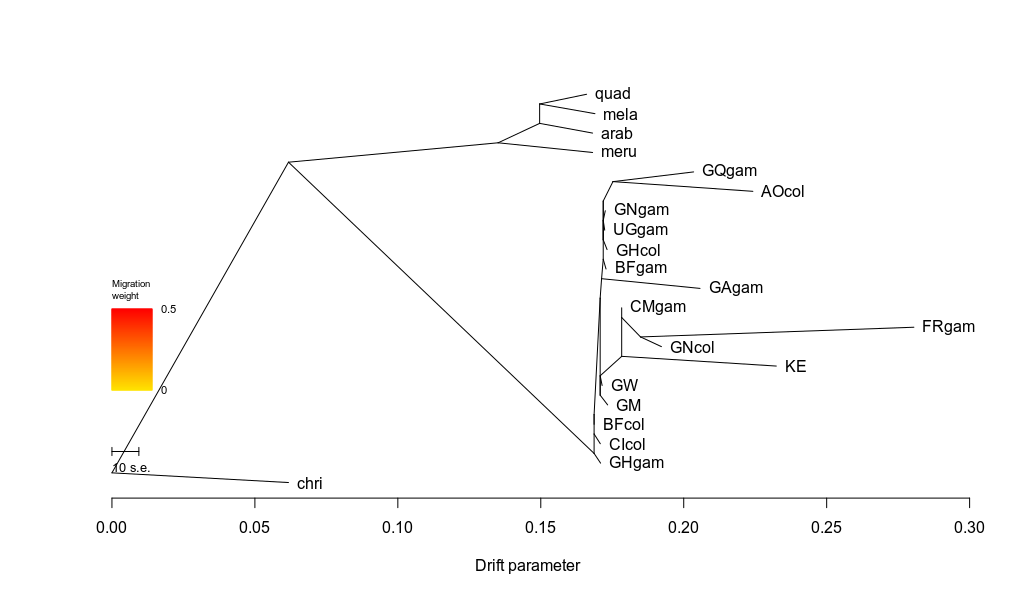

In [5]:
Image(filename='/home/randomx/Dropbox/Ag1000G_carlo/notebooks/images/treemix/X_free.png')

### X-speciation

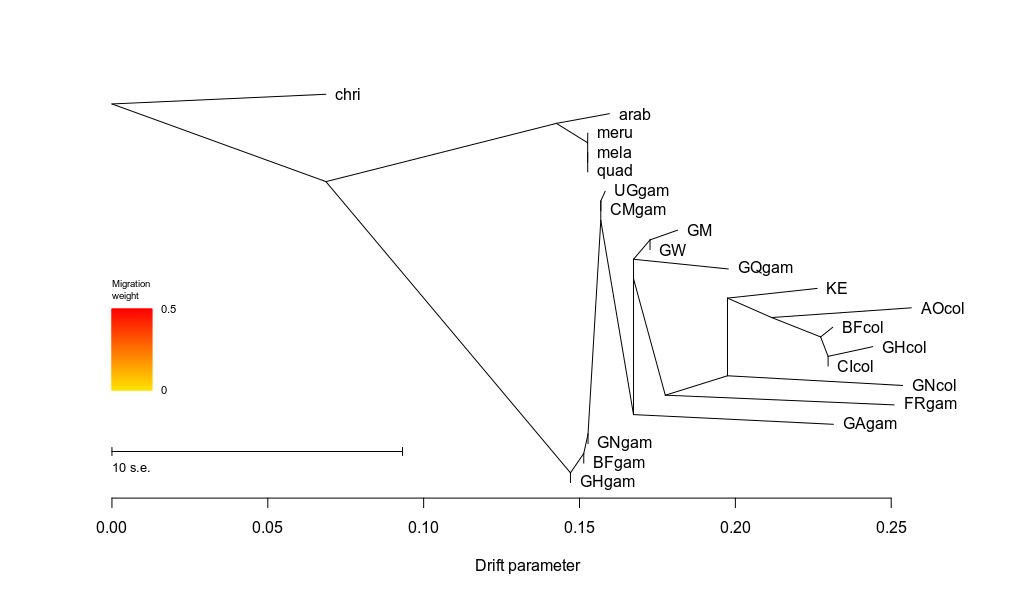

In [6]:
Image(filename='/home/randomx/Dropbox/Ag1000G_carlo/notebooks/images/treemix/X_speciation.png')